In [3]:
import scipy.io
import scipy.ndimage
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from Solver import nummodel, nummodel_jac, explicit_solve, implicit_solve
from Utility import interpolate_f2c, gradient_first_f2c
from timeit import default_timer
import torch

import sys
sys.path.append('../Utility')
import NeuralNet
import KalmanInversion 

# import imp
# imp.reload(KalmanInversion )
# imp.reload(NeuralNet )





# Reference quadratic function
 $$D(\theta) = \sqrt{\theta^2 + (\frac{\partial \theta}{\partial x})^2}$$

In [4]:
def permeability_ref(q, dq):
    return np.sqrt(q**2 + dq**2) 
def D_permeability_ref(q, dq):
    return q/np.sqrt(q**2 + dq**2), dq/np.sqrt(q**2 + dq**2)


# Generate Training data

100000 max q 0.15420940171016215
200000 max q 0.16105500139707368
300000 max q 0.1612135690621972
400000 max q 0.16121705302977674
500000 max q 0.1612171295332711
Last step increment is :  5.244638612664234e-07  last step is :  1.0869268110500834
100000 max q 0.22587322936901522
200000 max q 0.22798575440830837
300000 max q 0.22799540970998744
400000 max q 0.22799545330412824
500000 max q 0.22799545350094425
Last step increment is :  1.349271491532571e-09  last step is :  1.537146653703915
100000 max q 0.2784558907343084
200000 max q 0.27923521393101597
300000 max q 0.27923626097074616
400000 max q 0.27923626237508703
500000 max q 0.27923626237669746
Last step increment is :  1.10940588520717e-11  last step is :  1.8826124807061453
100000 max q 0.32211004034818674
200000 max q 0.3224341061004881
300000 max q 0.3224342624262979
400000 max q 0.3224342625014399
500000 max q 0.3224342625014399
Last step increment is :  0.0  last step is :  2.173853645031209
100000 max q 0.3603452553980225


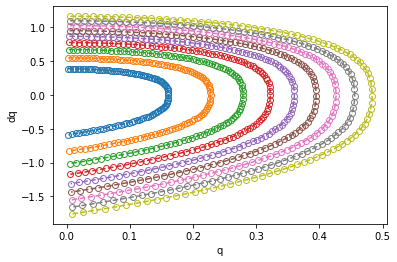

In [5]:
def generate_data_helper(permeability, D_permeability, f_func, L=1.0, Nx = 100):
    xx = np.linspace(0.0, L, Nx)
    dy = xx[1] - xx[0]
    f = f_func(xx)   
    dbc = np.array([0.0, 0.0]) 
       
    model = lambda q, yy, res : nummodel(permeability_ref, q, yy, res)
    xx, t_data, q_data = explicit_solve(model, f, dbc, dt = 5.0e-6, Nt = 500000, save_every = 100000, L = L)

    
    print("Last step increment is : ", np.linalg.norm(q_data[-1, :] - q_data[-2, :]), " last step is : ", np.linalg.norm(q_data[-1, :]))
    
    q = q_data[-1, :]
    q_c, dq_c = interpolate_f2c(q), gradient_first_f2c(q, dy)
    return xx, f, q, q_c, dq_c 


f_funcs = []
n_data = 10

for i in range(1,n_data):
    def func(xx, A = i):
        return A * xx
    f_funcs.append(func)
    
    
L = 1.0
Nx = 100
n_data = len(f_funcs)
xx, f, q, q_c, dq_c = np.zeros((n_data, Nx)), np.zeros((n_data, Nx)), np.zeros((n_data, Nx)), np.zeros((n_data, Nx-1)), np.zeros((n_data, Nx-1))


for i in range(n_data):
    xx[i, :], f[i, :], q[i, :], q_c[i, :], dq_c[i, :] = generate_data_helper(permeability_ref, D_permeability_ref, f_funcs[i], L=L, Nx=Nx)
    

# visualize data

plt.figure()
for i in range(n_data):
    plt.plot(q_c[i, :], dq_c[i, :],  "--o", fillstyle="none")

plt.xlabel("q")
plt.ylabel("dq")
plt.show()

In [85]:
def creat_nn_model(ind, outd, layers, width, activation, initializer, outputlayer, params):
#     layers = 2
#     activation = "sigmoid" 
#     initializer = "default"
#     outputlayer = "square"

    net = NeuralNet.FNN(ind, outd, layers, width, activation, initializer, outputlayer) 
    net.update_params(params)
    return net


def nn_model(x, net):
    return net(torch.tensor(x, dtype=torch.float32)).detach().numpy().flatten() 


# Training Loss : || d(D dq/dy)/dy + f(x)|| on the quadratic function

In [86]:
def loss_aug(s_param, params):
    xx, q = s_param.xx, s_param.q
    input_dim, output_dim, width = s_param.input_dim, s_param.output_dim, s_param.width
    activation, initializer, outputlayer = s_param.activation, s_param.initializer, s_param.outputlayer
    
    N_data, Nx = q.shape
    # does not include top and bottom nodes
    res = np.zeros((N_data, Nx - 2))
    
    def permeability(q, dq):
        x = np.vstack((q, dq)).T
        net =  creat_nn_model(input_dim, output_dim, layers, width, activation, initializer, outputlayer,  params)
        permeability = nn_model(x, net)
        
        return permeability

    
    for i in range(N_data):
        nummodel(permeability, q[i, :], xx[i, :], res[i, :])
        
    return np.hstack((-np.reshape(res, -1), params))


def loss(s_param, params):
    xx, q = s_param.xx, s_param.q
    input_dim, hidden_dim, output_dim = s_param.input_dim, s_param.hidden_dim, s_param.output_dim
    N_data, Nx = q.shape
    # does not include top and bottom nodes
    res = np.zeros((N_data, Nx - 2))
    
    def permeability(q, dq):
        x = np.vstack((q, dq)).T
        net =  creat_nn_model(input_dim, hidden_dim, output_dim, params)
        permeability = nn_model(x, net)
        # permeability = nn_model(torch.from_numpy(x.astype(np.float32))).detach().numpy().flatten()
        return permeability

    
    for i in range(N_data):
        nummodel(permeability, q[i, :], xx[i, :], res[i, :])
        
    return -np.reshape(res, -1)
    

## Start UKI

In [87]:
class PoissonParam:
    def __init__(self, xx, q, N_y, input_dim, hidden_dim, output_dim, aug=True):
        self.theta_names = ["hyperparameters"]
        self.xx = xx
        self.q  = q
        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        N_theta = input_dim*hidden_dim + hidden_dim + hidden_dim*output_dim + output_dim
        self.N_theta = N_theta
        
        
        self.N_y = N_y + N_theta if aug else N_y

In [88]:
aug = True

y = np.reshape(f[:, 1:Nx - 1], -1)
Sigma_eta = np.fabs(f[:, 1:Nx - 1])
for i in range(n_data):
    Sigma_eta[i, :] = np.mean(Sigma_eta[i, :])
Sigma_eta = np.diag(np.reshape((Sigma_eta*0.01)**2, -1))


N_y = len(y)
ind, outd, width = 2, 1, 10
layers = 2
activation, initializer, outputlayer = "relu", "default", "None"

s_param = PoissonParam(xx, q, N_y,  ind, width, outd, aug)


N_theta = s_param.N_theta

theta0_init = NeuralNet.FNN(ind, outd, layers, width, activation, initializer, outputlayer).get_params()
theta0_mean = np.zeros(N_theta)

theta0_cov = np.zeros((N_theta, N_theta))
np.fill_diagonal(theta0_cov, 10.0**2)  


y_aug = np.hstack((y, theta0_mean))
Sigma_eta_aug = block_diag(Sigma_eta, theta0_cov)
print(" N_theta = ", s_param.N_theta, " N_y = ", s_param.N_y)
print(" q = ", s_param.q.shape)


alpha_reg = 1.0
update_freq = 1
N_iter = 100
gamma = 1.0

if aug:
    uki_obj = KalmanInversion.UKI_Run(s_param, loss_aug, 
        theta0_mean, theta0_init, theta0_cov,
        y_aug, Sigma_eta_aug,
        alpha_reg,
        gamma,
        update_freq, 
        N_iter)
else:
    uki_obj = KalmanInversion.UKI_Run(s_param, loss, 
        theta0_mean, theta0_init, theta0_cov,
        y, Sigma_eta,
        alpha_reg,
        gamma,
        update_freq,
        N_iter)

 N_theta =  41  N_y =  923
 q =  (9, 100)
ukiobj.gamma :  1.0
len(ukiobj.opt_error) :  0 1
optimization error at iter  0  =  23989718985912.14
len(ukiobj.theta_cov) :  0 2
Frobenius norm of the covariance at iter  0  =  640.3124237432849
ukiobj.gamma :  1.0
len(ukiobj.opt_error) :  1 2
optimization error at iter  1  =  14511734568371.047
len(ukiobj.theta_cov) :  1 3
Frobenius norm of the covariance at iter  1  =  494.75710208880923
ukiobj.gamma :  1.0
len(ukiobj.opt_error) :  2 3
optimization error at iter  2  =  1455233410372.1155
len(ukiobj.theta_cov) :  2 4
Frobenius norm of the covariance at iter  2  =  0.00010051844009824051
ukiobj.gamma :  1.0
len(ukiobj.opt_error) :  3 4
optimization error at iter  3  =  478684532001.6025
len(ukiobj.theta_cov) :  3 5
Frobenius norm of the covariance at iter  3  =  2.2351410804333862e-07
ukiobj.gamma :  2.0
len(ukiobj.opt_error) :  4 5
optimization error at iter  4  =  41487448107.92327
len(ukiobj.theta_cov) :  4 6
Frobenius norm of the covarianc

In [89]:
trained_net = creat_nn_model(ind, width, outd, uki_obj.theta_mean[-1])

In [90]:
print(trained_net.modus['LinM{}'.format(1)].weight)
print(trained_net.modus['LinM{}'.format(1)].bias)
print(trained_net.modus['LinMout'].weight)
print(trained_net.modus['LinMout'].bias)

Parameter containing:
tensor([[ 1.0223e+02,  1.2572e+02],
        [ 2.9627e-01, -1.5829e-02],
        [-3.0853e+00,  9.0627e-01],
        [-6.9105e+01, -9.8200e+01],
        [-3.5469e+00,  7.9628e+00],
        [-1.1712e+00,  2.8041e-01],
        [ 7.4113e-01, -8.4861e+00],
        [ 6.5959e+00, -7.1504e+00],
        [-7.3224e+01, -1.0118e+02],
        [-2.4850e+01,  1.3483e+02]], grad_fn=<CopySlices>)
Parameter containing:
tensor([-30.3832,  -0.5935,  -1.4027,  21.2001,   0.0764,   3.3219,   1.1915,
         -1.6097,  22.3126,  -2.7868], grad_fn=<CopySlices>)
Parameter containing:
tensor([[  2.8160, -33.5080,  -1.6812, -21.2817,   2.8852, -34.3035,   1.6977,
           1.2591,  23.8629,  -1.2631]], grad_fn=<CopySlices>)
Parameter containing:
tensor([40.4125], grad_fn=<CopySlices>)


# Direct test

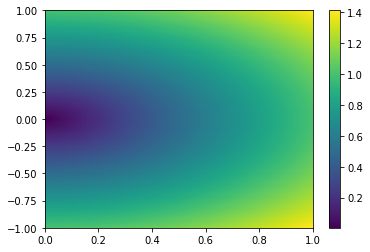

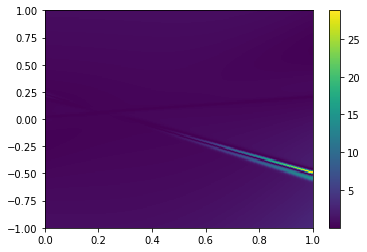

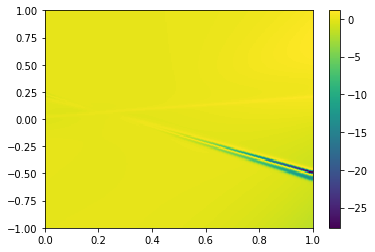

In [91]:
N_test_1d = 200
L_test_1d = 1.0
N_test = N_test_1d**2

x1_test_1d = np.linspace(0, L_test_1d, N_test_1d)
x2_test_1d = np.linspace(-L_test_1d, L_test_1d, N_test_1d)
X_test_2d, Y_test_2d = np.meshgrid(x1_test_1d, x2_test_1d)

x_test = np.vstack((X_test_2d.reshape(-1), Y_test_2d.reshape(-1))).T    
y_test = permeability_ref(x_test[:, 0], x_test[:, 1]).reshape((N_test, 1))


y_pred = nn_model(x_test, trained_net)  

y_test_2d = y_test.reshape((N_test_1d,N_test_1d))
y_pred_2d = y_pred.reshape((N_test_1d,N_test_1d))

plt.figure()
plt.pcolormesh(X_test_2d, Y_test_2d, y_test_2d)
plt.colorbar()

plt.figure()
plt.pcolormesh(X_test_2d, Y_test_2d, y_pred_2d)
plt.colorbar()

plt.figure()
plt.pcolormesh(X_test_2d, Y_test_2d, y_test_2d - y_pred_2d)
plt.colorbar()


# Plug-in test

In [ ]:
def permeability_nn(q, dq):
    
    x = np.vstack((q, dq)).T
    
    permeability = nn_model(x, trained_net)  
    
    return permeability

# def D_permeability_nn(q, dq):
    
#     Nx = q.size
#     Dq, Ddq = np.zeros(Nx), np.zeros(Nx)
    
#     for i in range(Nx):
#         x = torch.from_numpy(np.array([[q[i],dq[i]]]).astype(np.float32))
#         x.requires_grad = True
#         y = trained_nn_model(x)  #.detach().numpy().flatten()
#         d = torch.autograd.grad(y, x)[0].numpy().flatten()
#         Dq[i], Ddq[i] = d[0], d[1]
    
    
#     return Dq, Ddq

L = 1.0
Nx = 100
xx_test = np.linspace(0.0, L, Nx)
f_test = 6*(1-2*xx_test)**2 - 2*(xx_test - xx_test**2)*(1 - 2*xx_test)**2 + 2*(xx_test - xx_test**2)**2 + 2 
q_sol = -xx*(xx - 1)
dbc = np.array([0.0, 0.0]) 

MODEL = "exp_nummodel"

if MODEL == "exp_nummodel":
    
    model = lambda q, xx, res : nummodel(permeability_ref, q, xx, res)
    _, t_data_ref, q_data_ref = explicit_solve(model, f_test, dbc, dt = 2.0e-6, Nt = 500000, save_every = 100000, L = L)

    model = lambda q, xx, res : nummodel(permeability_nn, q, xx, res)
    _, t_data, q_data = explicit_solve(model, f_test, dbc, dt = 2.0e-6, Nt = 500000, save_every = 100000, L = L)

# elif MODEL == "imp_nummodel":
    
#     model = lambda q, xx, res, V : nummodel_jac(permeability_ref, q, xx, res, V, True, D_permeability_ref)  
#     _, t_data_ref, q_data_ref = implicit_solve(model, f_test, dbc, dt = 1.0e-3, Nt = 200, save_every = 100, L = L)
    
#     model = lambda q, xx, res, V : nummodel_jac(permeability_nn, q, xx, res, V, True, D_permeability_nn)  
#     _, t_data, q_data = implicit_solve(model, f_test, dbc, dt = 1.0e-3, Nt = 200, save_every = 100, L = L)
    
# elif MODEL == "imp_Newton_nummodel":
    
#     model = lambda q, xx, res, V : nummodel_jac(permeability_ref, q, xx, res, V, True, D_permeability_ref)  
#     _, t_data_ref, q_data_ref = implicit_Newton_solve(model, f_test, dbc, dt = 1.0e-3, Nt = 200, save_every = 100, L = L, Newton_eps = 1e-3, Newton_maxiterstep = 1000)
    
#     model = lambda q, xx, res, V : nummodel_jac(permeability_nn, q, xx, res, V, True, D_permeability_nn)  
#     _, t_data, q_data = implicit_Newton_solve(model, f_test, dbc, dt = 1.0e-3, Nt = 200, save_every = 100, L = L, Newton_eps = 1e-3, Newton_maxiterstep = 1000)
    
else:
    print("ERROR")


plt.figure()
plt.plot(xx_test, q_data[-1, :],  "--o", fillstyle="none", label="q")
plt.plot(xx_test, q_data_ref[-1, :],  "--*", label="q ref")

plt.xlabel("y")
plt.legend()
plt.show()

100000 max q 0.3612968630051589
200000 max q 0.3833724143438851
300000 max q 0.3838681017323774
400000 max q 0.3838789824417029
500000 max q 0.38387922115718404
100000 max q 0.3632702461175347
200000 max q 0.3880876424103002
300000 max q 0.3887187757173874
